In [31]:
import numpy as np
import pandas as pd
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from IPython.display import display # Allows the use of display() for DataFrames

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [32]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Data overview 

In [33]:
train_df.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [34]:
test_df.head()

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49342 entries, 0 to 49341
Columns: 4992 entries, ID to 9fc776466
dtypes: float64(4991), object(1)
memory usage: 1.8+ GB


In [36]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


## data type

In [37]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,3147
1,float64,1845
2,object,1


In [38]:
dtype_df = test_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,float64,4991
1,object,1


## Checking for missing data

### test data

In [39]:
total = test_df.isnull().sum().sort_values(ascending = False)
percent = (test_df.isnull().sum()/test_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()


,9fc776466,f0aa40974,c3726f249,a682ef110,b452ba57e,08448215c,fee2d3bf9,c2d200f0e,083640132,7af000ac2,...,007d71f12,f1e0ada11,99fc30923,4d3fb93d9,8e978ee65,c30399758,e70581bed,b22eb2036,7f0d863ba,ID
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### train data

In [40]:
total = train_df.isnull().sum().sort_values(ascending = False)
percent = (train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()


,9fc776466,083640132,26e2c24e3,c3726f249,a682ef110,b452ba57e,08448215c,fee2d3bf9,c2d200f0e,f0aa40974,...,8c8616b62,007d71f12,f1e0ada11,99fc30923,4d3fb93d9,8e978ee65,c30399758,e70581bed,b22eb2036,ID
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Checking for constant features

In [41]:
colsToRemove = []
for col in train_df.columns:
    if col != 'ID' and col != 'target':
        if train_df[col].std() == 0: 
            colsToRemove.append(col)
        
train_df.drop(colsToRemove, axis=1, inplace=True)

test_df.drop(colsToRemove, axis=1, inplace=True) 

print("Removed `{}` Constant Columns\n".format(len(colsToRemove)))
print(colsToRemove)

Removed `256` Constant Columns

['d5308d8bc', 'c330f1a67', 'eeac16933', '7df8788e8', '5b91580ee', '6f29fbbc7', '46dafc868', 'ae41a98b6', 'f416800e9', '6d07828ca', '7ac332a1d', '70ee7950a', '833b35a7c', '2f9969eab', '8b1372217', '68322788b', '2288ac1a6', 'dc7f76962', '467044c26', '39ebfbfd9', '9a5ff8c23', 'f6fac27c8', '664e2800e', 'ae28689a2', 'd87dcac58', '4065efbb6', 'f944d9d43', 'c2c4491d5', 'a4346e2e2', '1af366d4f', 'cfff5b7c8', 'da215e99e', '5acd26139', '9be9c6cef', '1210d0271', '21b0a54cb', 'da35e792b', '754c502dd', '0b346adbd', '0f196b049', 'b603ed95d', '2a50e001c', '1e81432e7', '10350ea43', '3c7c7e24c', '7585fce2a', '64d036163', 'f25d9935c', 'd98484125', '95c85e227', '9a5273600', '746cdb817', '6377a6293', '7d944fb0c', '87eb21c50', '5ea313a8c', '0987a65a1', '2fb7c2443', 'f5dde409b', '1ae50d4c3', '2b21cd7d8', '0db8a9272', '804d8b55b', '76f135fa6', '7d7182143', 'f88e61ae6', '378ed28e0', 'ca4ba131e', '1352ddae5', '2b601ad67', '6e42ff7c7', '22196a84c', '0e410eb3d', '992e6d1d3', '90a7

## Remove duplicate value

In [50]:
%%time
def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups
    dups = []

    for t, v in groups.items():

        cs = frame[v].columns
        vs = frame[v]
        lcs = len(cs)

        for i in range(lcs):
            ia = vs.iloc[:,i].values
            for j in range(i+1, lcs):
                ja = vs.iloc[:,j].values
                if np.array_equal(ia, ja):
                    dups.append(cs[i])
                    break

    return dups

colsToRemove = duplicate_columns(train_df)
print(colsToRemove)

['34ceb0081', '8d57e2749', '168b3e5bc', 'a765da8bc', 'acc5b709d']
Wall time: 4min 41s


In [51]:
train_df.drop(colsToRemove, axis=1, inplace=True) 

test_df.drop(colsToRemove, axis=1, inplace=True)

print("Removed `{}` Duplicate Columns\n".format(len(colsToRemove)))
print(colsToRemove)


Removed `5` Duplicate Columns

['34ceb0081', '8d57e2749', '168b3e5bc', 'a765da8bc', 'acc5b709d']


## Drop sparce data

In [54]:
def drop_sparse(train, test):
    flist = [x for x in train.columns if not x in ['ID','target']]
    for f in flist:
        if len(np.unique(train[f]))<2:
            train.drop(f, axis=1, inplace=True)
            test.drop(f, axis=1, inplace=True)
    return train, test

In [56]:
train_df, test_df = drop_sparse(train_df, test_df)

In [59]:
gc.collect()
print("Train set size: {}".format(train_df.shape))
print("Test set size: {}".format(test_df.shape))

Train set size: (4459, 4732)
Test set size: (49342, 4731)


# Splitting data into train and test

In [60]:
X_train = train_df.drop(["ID", "target"], axis=1)
y_train = np.log1p(train_df["target"].values)

X_test = test_df.drop(["ID"], axis=1)

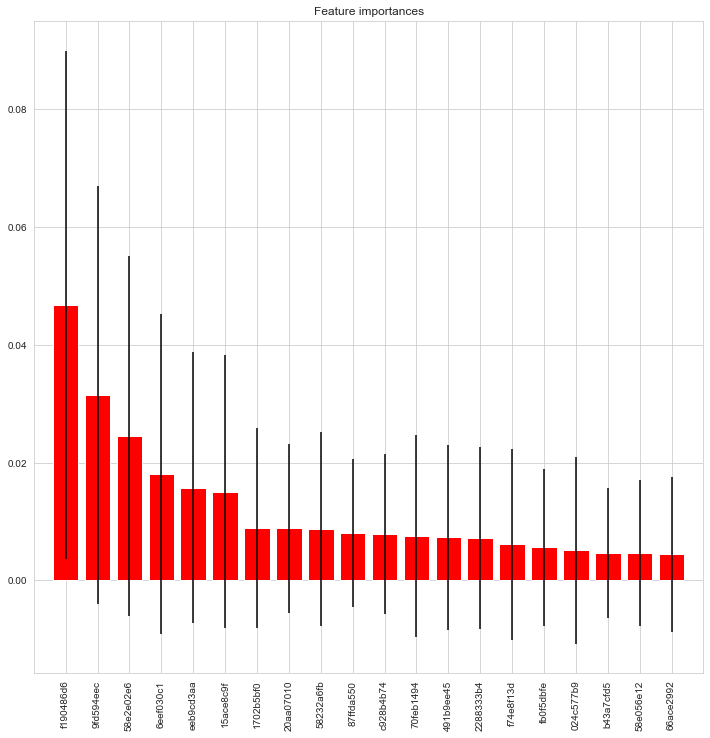

In [62]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(X_train, y_train)

## plot the importances ##
feat_names = X_train.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [63]:
dev_X, val_X, dev_y, val_y = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

# LightGBM

In [65]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.004,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=150, 
                      evals_result=evals_result)
    
    pred_test_y = np.expm1(model.predict(test_X, num_iteration=model.best_iteration))
    return pred_test_y, model, evals_result

## Training LGB

In [66]:
pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, X_test)
print("LightGBM Training Completed...")

[LightGBM] [Warning] Unknown parameter: bagging_frequency
Training until validation scores don't improve for 100 rounds
[150]	training's rmse: 1.50845	valid_1's rmse: 1.539
[300]	training's rmse: 1.3446	valid_1's rmse: 1.46591
[450]	training's rmse: 1.23333	valid_1's rmse: 1.43454
[600]	training's rmse: 1.15002	valid_1's rmse: 1.42157
[750]	training's rmse: 1.08396	valid_1's rmse: 1.41615
[900]	training's rmse: 1.03041	valid_1's rmse: 1.41411
Early stopping, best iteration is:
[877]	training's rmse: 1.03806	valid_1's rmse: 1.4137
LightGBM Training Completed...


## KFold cross validation

In [80]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
pred_test_full = 0
for dev_index, val_index in kf.split(X_train):
    dev_X, val_X = X_train.loc[dev_index,:], X_train.loc[val_index,:]
    dev_y, val_y = y_train[dev_index], y_train[val_index]
    pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, X_test)
    pred_test_full += pred_test
pred_test_full /= 5.
pred_test_full = np.expm1(pred_test_full)

[LightGBM] [Warning] Unknown parameter: bagging_frequency
Training until validation scores don't improve for 100 rounds
[150]	training's rmse: 1.50438	valid_1's rmse: 1.54841
[300]	training's rmse: 1.34353	valid_1's rmse: 1.47737
[450]	training's rmse: 1.23218	valid_1's rmse: 1.44323
[600]	training's rmse: 1.14862	valid_1's rmse: 1.42593
[750]	training's rmse: 1.08313	valid_1's rmse: 1.41699
[900]	training's rmse: 1.03063	valid_1's rmse: 1.41573
Early stopping, best iteration is:
[834]	training's rmse: 1.05262	valid_1's rmse: 1.41532
[LightGBM] [Warning] Unknown parameter: bagging_frequency
Training until validation scores don't improve for 100 rounds
[150]	training's rmse: 1.50056	valid_1's rmse: 1.57803
[300]	training's rmse: 1.34392	valid_1's rmse: 1.4891
[450]	training's rmse: 1.23307	valid_1's rmse: 1.4399
[600]	training's rmse: 1.14974	valid_1's rmse: 1.41483
[750]	training's rmse: 1.08482	valid_1's rmse: 1.40285
[900]	training's rmse: 1.03151	valid_1's rmse: 1.39679
[1050]	train

## feature importance

In [67]:
print("Features Importance...")
gain = model.feature_importance('gain')
featureimp = pd.DataFrame({'feature':model.feature_name(), 
                   'split':model.feature_importance('split'), 
                   'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(featureimp[:50])

Features Importance...
        feature  split      gain
4130  f190486d6    795  9.217105
2375  58e2e02e6    703  5.445323
3465  eeb9cd3aa    662  4.520153
4020  15ace8c9f    514  3.023536
2614  9fd594eec    362  2.933775
8     20aa07010    425  2.229353
3571  58232a6fb    371  1.503661
834   6eef030c1    313  1.411549
1457  b43a7cfd5    385  1.285384
3661  491b9ee45    276  1.066377
2687  fb0f5dbfe    408  1.065763
1482  024c577b9    260  0.936856
2079  58e056e12    338  0.904839
4508  c47340d97    320  0.878493
4343  1702b5bf0    282  0.873053
3867  2288333b4    174  0.867616
4185  f74e8f13d    338  0.832932
566   66ace2992    280  0.794802
828   6786ea46d    175  0.771087
3722  d6bb78916    286  0.767982
3791  ed8ff54b5    166  0.763305
3220  ced6a7e91    247  0.758728
4028  5c6487af1    193  0.704117
1378  6cf7866c1    162  0.696926
863   fc99f9426    235  0.679075
3886  50e4f96cf    140  0.666640
34    87ffda550    163  0.623059
213   186b87c05     68  0.618299
853   bc70cbc26    1

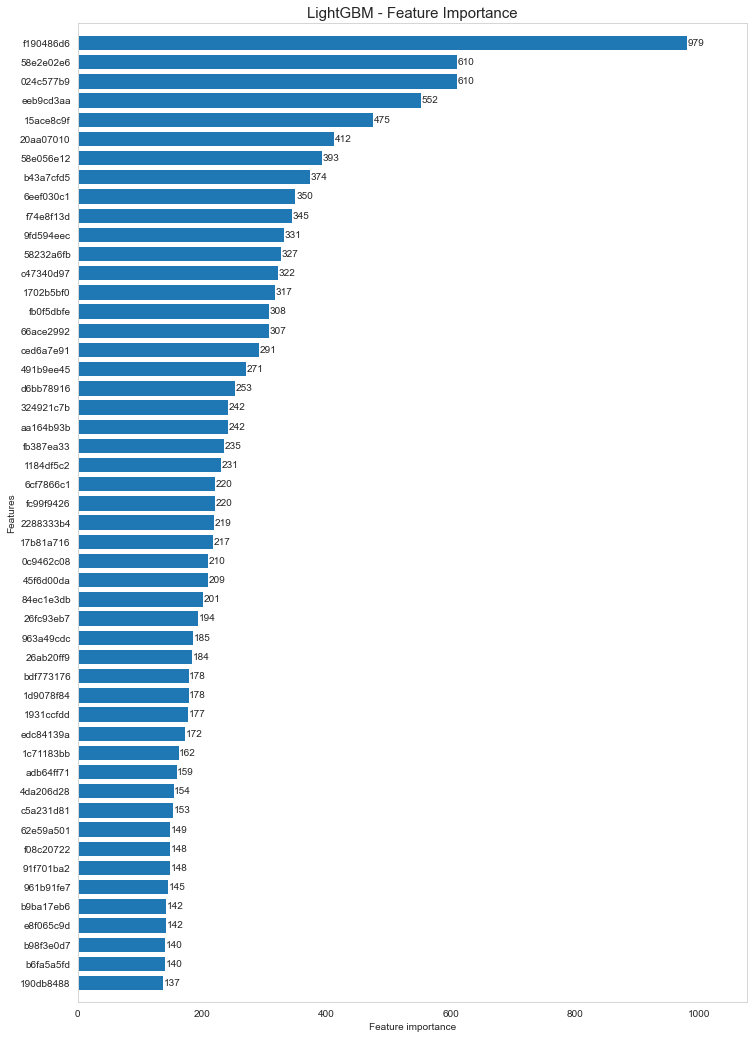

In [81]:
### Feature Importance ###
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

# XGB Modeling

In [68]:
def run_xgb(train_X, train_y, val_X, val_y, test_X):
    params = {'objective': 'reg:linear', 
          'eval_metric': 'rmse',
          'eta': 0.001,
          'max_depth': 10, 
          'subsample': 0.6, 
          'colsample_bytree': 0.6,
          'alpha':0.001,
          'random_state': 42, 
          'silent': True}
    
    tr_data = xgb.DMatrix(train_X, train_y)
    va_data = xgb.DMatrix(val_X, val_y)
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    model_xgb = xgb.train(params, tr_data, 2000, watchlist, maximize=False, early_stopping_rounds = 100, verbose_eval=100)
    
    dtest = xgb.DMatrix(test_X)
    xgb_pred_y = np.expm1(model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit))
    
    return xgb_pred_y, model_xgb


## Training XGB

In [72]:
pred_test_xgb, model_xgb = run_xgb(dev_X, dev_y, val_X, val_y, X_test)
print("XGB Training Completed...")

[23:22:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[23:22:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:14.08765	valid-rmse:14.07678
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[100]	train-rmse:12.76875	valid-rmse:12.75679
[200]	train-rmse:11.57719	valid-rmse:11.56388
[300]	train-rmse:10.50042	valid-rmse:10.48590
[400]	train-rmse:9.52826	valid-rmse:9.51335
[500]	train-rmse:8.65075	valid-rmse:8.63628
[600]	train-rmse:7.8585

# Catboost

In [74]:
cb_model = CatBoostRegressor(iterations=500,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)

## Fit Catboost

In [75]:
cb_model.fit(dev_X, dev_y,
             eval_set=(val_X, val_y),
             use_best_model=True,
             verbose=50)

0:	learn: 1.7518683	test: 1.6878429	best: 1.6878429 (0)	total: 1.53s	remaining: 12m 43s
50:	learn: 1.4789181	test: 1.5197196	best: 1.5197196 (50)	total: 1m 14s	remaining: 10m 51s
100:	learn: 1.3788775	test: 1.4780503	best: 1.4780503 (100)	total: 2m 27s	remaining: 9m 43s
150:	learn: 1.3203081	test: 1.4647232	best: 1.4647232 (150)	total: 3m 41s	remaining: 8m 31s
200:	learn: 1.2546056	test: 1.4505032	best: 1.4504536 (198)	total: 4m 54s	remaining: 7m 17s
250:	learn: 1.1817435	test: 1.4381513	best: 1.4381513 (250)	total: 6m 7s	remaining: 6m 4s
300:	learn: 1.1208241	test: 1.4320748	best: 1.4314980 (297)	total: 7m 20s	remaining: 4m 51s
350:	learn: 1.0770301	test: 1.4298988	best: 1.4297384 (347)	total: 8m 33s	remaining: 3m 38s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1.428228031
bestIteration = 376

Shrink model to first 377 iterations.


In [76]:
pred_test_cat = np.expm1(cb_model.predict(X_test))

# Combine Predictions

In [77]:
sub = pd.read_csv('sample_submission.csv')

sub_lgb = pd.DataFrame()
sub_lgb["target"] = pred_test

sub_xgb = pd.DataFrame()
sub_xgb["target"] = pred_test_xgb

sub_cat = pd.DataFrame()
sub_cat["target"] = pred_test_cat

sub["target"] = (sub_lgb["target"] * 0.5 + sub_xgb["target"] * 0.3 + sub_cat["target"] * 0.2)
print(sub.head())
sub.to_csv('sub_lgb_xgb_cat.csv', index=False)

          ID        target
0  000137c73  1.280428e+06
1  00021489f  1.342636e+06
2  0004d7953  1.932502e+06
3  00056a333  3.840496e+06
4  00056d8eb  1.443060e+06
